# Table of Contents


- **Geting Started**
    - Set Up Environment
    - Import Data
- **ModelSearcher**
    - TBD

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Getting Started

In this notebook, we'll see how to do find the best potential hyper-parameters for a given model via the **`ModelTuner`** class.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [2]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreClassificationDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb).

In [3]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [4]:
explore.dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# `ModelSearcher`

A "Searcher" searches across different models and hyper-parameters (or the same models and hyper-parameters with different tranformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

The data is split (via a Splitter) into training and holding sets. The training set will be
    used for selecting the "best" hyper parameters via resampling and then the model will be
    retrained and evaluated with selected hyper parameters with the holdout set.

In [20]:
# define the transformations that will be applied to ALL models
global_transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                          CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                          ImputationTransformer(),
                          DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

score_list = [AucRocScore(positive_class='lived'),
              SensitivityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# Logistic Regression Hyper-Param Grid
log_params_dict = dict(penalty=['l1', 'l2'],
                      regularization_inverse=[0.001, 0.01, 0.1, 1, 100, 1000])
log_grid = HyperParamsGrid(params_dict=log_params_dict)

# get the expected columns at the time we do the training, based on the transformations 
columns = TransformerPipeline.get_expected_columns(transformations=global_transformations, data=explore.dataset.drop(columns=[target_variable]))

# Random Forest Hyper-Param Grid

rm_params_dict = dict(criterion='gini',
                   max_features=[int(round(len(columns) ** (1 / 2.0))),
                                 int(round(len(columns) / 2)),
                                 len(columns) - 1],
                   n_estimators=[10, 100, 500],
                   min_samples_leaf=[1, 50, 100])
rm_grid = HyperParamsGrid(params_dict=rm_params_dict)

infos = [ModelInfo(description='dummy_stratified',
                   model=DummyClassifier(DummyClassifierStrategy.STRATIFIED),
                   transformations=None,
                   hyper_params=None,
                   hyper_params_grid=None),
         ModelInfo(description='dummy_frequent',
                   model=DummyClassifier(DummyClassifierStrategy.MOST_FREQUENT),
                   transformations=None,
                   hyper_params=None,
                   hyper_params_grid=None),
         ModelInfo(description='Logistic Regression',
                   model=LogisticClassifier(),
                   # transformations specific to this model
                   transformations=[CenterScaleTransformer(),
                                    RemoveCorrelationsTransformer()],
                   hyper_params=LogisticClassifierHP(),
                   hyper_params_grid=log_grid),
         ModelInfo(description='Random Forest',
                   model=RandomForestClassifier(),
                   transformations=None,
                   hyper_params=RandomForestHP(),
                   hyper_params_grid=rm_grid)]

searcher = ModelSearcher(global_transformations=[x.clone() for x in global_transformations],
                         model_infos=infos,
                         splitter=ClassificationStratifiedDataSplitter(holdout_ratio=0.25),
                         resampler_function=lambda m, mt: RepeatedCrossValidationResampler(
                             model=m,
                             transformations=mt,
                             scores=score_list,
                             folds=5,
                             repeats=3))
searcher.search(data=explore.dataset, target_variable='Survived')

In [22]:
searcher.results.model_descriptions

['dummy_stratified', 'dummy_frequent', 'Logistic Regression', 'Random Forest']

In [23]:
searcher.results.model_names

['DummyClassifier',
 'DummyClassifier',
 'LogisticClassifier',
 'RandomForestClassifier']

In [25]:
searcher.results.holdout_scores

,AUC_ROC,sensitivity
dummy_stratified,0.553047,0.441860
dummy_frequent,0.500000,0.000000
Logistic Regression,0.838016,0.709302
Random Forest,0.808055,0.651163


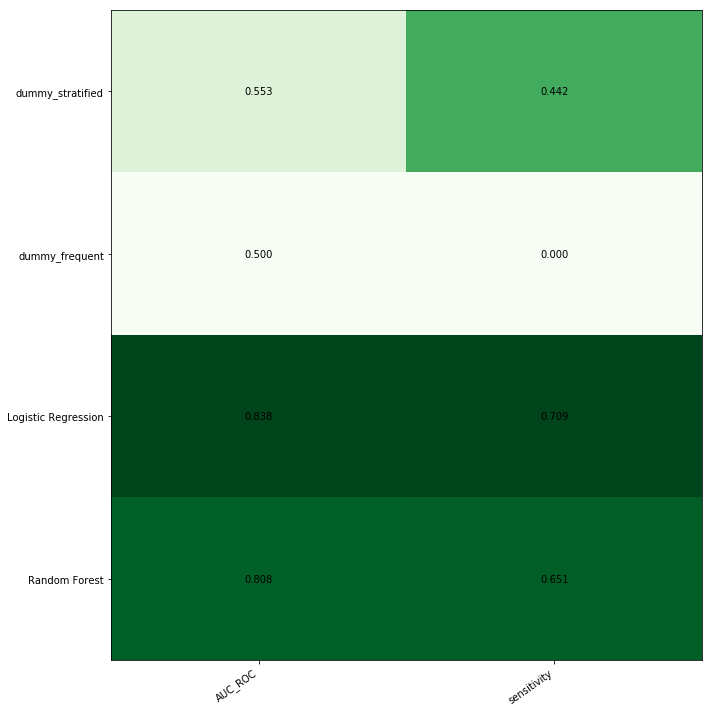

In [33]:
searcher.results.plot_holdout_scores()

In [26]:
searcher.results.best_model_index

2

"best" model according to the holdout set is Logistic Regression, but best model regarding resampled scored is Random Forest

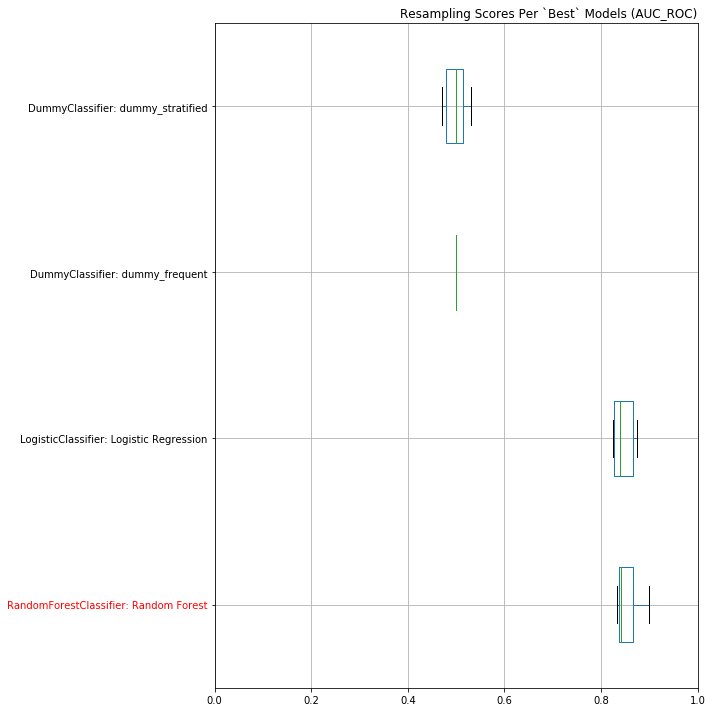

In [31]:
searcher.results.plot_resampled_scores(metric=Metric.AUC_ROC)

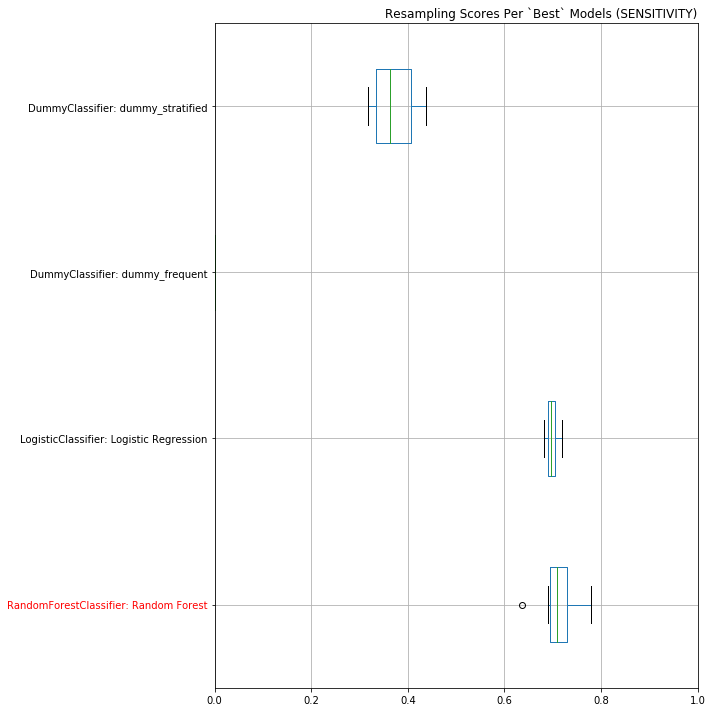

In [32]:
searcher.results.plot_resampled_scores(metric=Metric.SENSITIVITY)